## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd "/content/drive/My Drive/disso/tacotron2"
!apt-get install sox
!pip install -r requirements.txt

In [ ]:
pip install unidecode

In [ ]:
pip install tensorboardX

In [ ]:
pip install tensorflow==1.15.2

In [ ]:
pip install numba==0.48

#### Import libraries and setup matplotlib

In [1]:
%cd "/content/drive/My Drive/disso/tacotron2"

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
%cd "/content/drive/My Drive/disso/tacotron2/waveglow"
from denoiser import Denoiser

/content/drive/My Drive/disso/tacotron2
/content/drive/My Drive/disso/tacotron2/waveglow


In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [4]:
%cd "/content/drive/My Drive/disso/tacotron2/outdir"
checkpoint_path = '/content/drive/My Drive/files/tacotron2_statedict.pt'
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

/content/drive/My Drive/disso/tacotron2/outdir


#### Load WaveGlow for mel2audio synthesis and denoiser

In [ ]:
%cd "/content/drive/My Drive/disso/tacotron2"
waveglow_path = '/content/drive/My Drive/files/waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [6]:
text = "This is the stock nvidia model! Congratulations, you have succesfully installed tacotron2. Now for the hard part, enjoy!"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

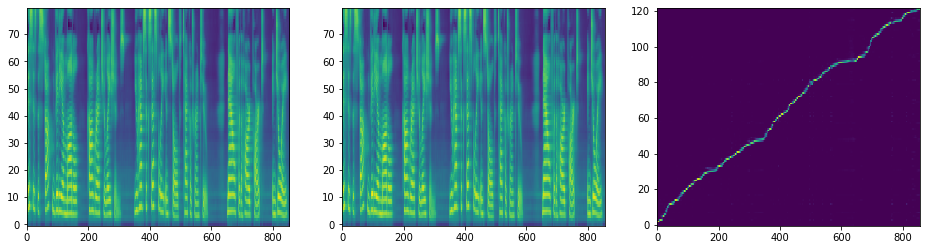

In [7]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [13]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=1)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [14]:
audio_denoised = denoiser(audio, strength=0.005)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

In [ ]:
%load_ext tensorboard
import tensorflow as tf
import datetime, os
%cd "/content/drive/My Drive/disso/tacotron2"
%tensorboard --logdir=outdir/logdir

/content/drive/My Drive/disso/tacotron2
